In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools
from einops import rearrange
import tqdm
import time
import optax

import warnings
warnings.filterwarnings("ignore")

# Generative Adversarial Networks

> The **generative adversarial network** generates high-quality samples via an adversarial objective.

As the story goes, [a researcher](https://www.deeplearning.ai/the-batch/ian-goodfellow-a-man-a-plan-a-gan/) was at the bar frustrated by the blurry results of their generative image model. "It's so easy to tell the fakes images apart", the researcher exclaimed, "even a tiny model could do it". The idea was born right there---what if we trained a generative model towards a 'realness' objective defined by *another learned model?*

## An Adversarial Game

Picture a bank and a counterfieter. At the beginning, the counterfieter's fakes are easy to spot. However, the counterfieter starts to realize how the bank is telling the fakes apart, and can improve her strategies. At the the same time, the bank doesn't give up, and also keeps learning how to discriminate the fake money. After a long period of back-and-forth, the competition has led the counterfieter to create perfect replicas.

The generative adversarial network (GAN) instantiates this concept into machine learning. Two networks are simultaneously trained -- a [noise-conditioned](4-models/variational-auto-encoders) *generator* network, along with a binary [classifier](4-models/classifiers) known as the *discriminiator* network. 

The discriminator is trained to classify images as real or fake, with the real images coming from the dataset, and the fake images coming from the generator network. Then, the generator network is trained by backpropagating the classification signal *through the discriminator*, adjusting parameters to generate images more likely to be labelled as real.

![gan](gan.png)
> Fig: The discriminator tries to correctly classify real and fake images, while the generator attempts to fool it. The two networks are in an adversarial game.

We can also express the GAN objective in terms of a minimax equation:

$$
\text{min}_\theta \; \text{max}_\phi \; \mathbb{E} \left[ \log D_\phi(x) + \log (1 - D_\phi(G_\theta(z))) \right]
$$
where $\theta, \phi$ represent the generator and discriminator parameters, $x$ represents real samples from the data, and $z$ is random noise.

## Implementation: GAN on CelebAHQ
Let's implement a simple GAN to generate CelebA images. We'll again use our [jaxtransformer](../1-numerical-toolkit/jaxtransformer) library to define a transformer backbone for the generator and discriminator models.

In [ ]:
from jaxtransformer.transformer import TransformerBackbone
from jaxtransformer.modalities import PatchEmbed, PatchOutput, get_2d_sincos_pos_embed
from jaxtransformer.utils.train_state import TrainState
from jaxtransformer.utils.datasets import get_dataset
dataset = get_dataset('celebahq64', 64, is_train=True) # Normalized to [-1, 1].

class Discriminator(nn.Module):
    hidden_size: int
    patch_size: int
    num_patches: int

    @nn.compact
    def __call__(self, x):
        x = PatchEmbed(patch_size=self.patch_size, hidden_size=self.hidden_size)(x)
        x = x + get_2d_sincos_pos_embed(None, self.hidden_size, self.num_patches)
        class_token = nn.Embed(num_embeddings=1, features=self.hidden_size)(jnp.zeros((x.shape[0], 1), dtype=jnp.int32))
        x = jnp.concatenate([class_token, x], axis=1)
        x = TransformerBackbone(depth=4, num_heads=4, hidden_size=self.hidden_size, 
            use_conditioning=False, use_causal_masking=False, mlp_ratio=4)(x)
        x = nn.LayerNorm()(x)
        x = nn.Dense(features=1)(x[:, 0, :])
        return x
    
class Generator(nn.Module):
    hidden_size: int
    patch_size: int
    num_patches: int
    channels_out: int

    @nn.compact
    def __call__(self, z):
        c = nn.Dense(features=self.hidden_size)(z)
        x = nn.Dense(features=self.hidden_size)(z)
        x = jnp.tile(x[:, None, :], (1, self.num_patches, 1))
        x = x + get_2d_sincos_pos_embed(None, self.hidden_size, self.num_patches)
        x = TransformerBackbone(depth=4, num_heads=4, hidden_size=self.hidden_size, 
            use_conditioning=True, use_causal_masking=False, mlp_ratio=4)(x, c)
        x = nn.LayerNorm()(x)
        x = PatchOutput(patch_size=self.patch_size, channels=self.channels_out)(x)
        x = nn.tanh(x * 0.1)
        return x
discriminator = Discriminator(hidden_size=128, patch_size=8, num_patches=64)
generator = Generator(hidden_size=128, patch_size=8, num_patches=64, channels_out=3)

@jax.jit
def loss_fn_g(params, params_d, z):
    x = generator.apply({'params': params}, z)
    fake_pred = discriminator.apply({'params': params_d}, x)
    loss = -jnp.mean(jnp.log(nn.sigmoid(fake_pred)))
    return loss, x

@jax.jit
def loss_fn_d(params, x_real, x_fake):
    real_pred = discriminator.apply({'params': params}, x_real)
    fake_pred = discriminator.apply({'params': params}, x_fake)
    real_loss = -jnp.mean(jnp.log(nn.sigmoid(real_pred)))
    fake_loss = -jnp.mean(jnp.log(nn.sigmoid(1 - fake_pred)))
    loss = real_loss + fake_loss
    return loss

Note the loss function implementations above:
- Since we defined our discriminator to output a real-valued logit, we need to first transform the logit into a probablity with `nn.sigmoid`. Then, we optimize the log-likelihood. The discriminator and generator have *opposing* objectives with regards to classifying fake images.
- We don't actually optimize the generator towards minimizing $\log(1- D_\phi(G_\theta(z)))$ as in the original equation, but instead to maximize $\log(D_\phi(G_\theta(z)))$. This is known as the **non-saturating loss**, which provides a stronger gradient when the discriminator is strong.

In [3]:
# Generic model setup code.
tx = optax.adam(learning_rate=3e-4)
rng = jax.random.PRNGKey(0)
train_state_d = TrainState.create(rng, discriminator, (jnp.ones((1, 64, 64, 3)),), optax.adam(learning_rate=0.0002))
train_state_g = TrainState.create(rng, generator, (jnp.ones((1, 64)),), optax.adam(learning_rate=0.0002))
train_state = (train_state_d, train_state_g)

@jax.jit
def update_fn(train_state, x):
    ts_d, ts_g = train_state
    grad_fn_g = jax.value_and_grad(loss_fn_g, has_aux=True)
    grad_fn_d = jax.value_and_grad(loss_fn_d, has_aux=False)

    z_key, rng = jax.random.split(ts_d.rng)
    z = jax.random.normal(z_key, (x.shape[0], 64))
    (loss_g, x_fake), grad_g = grad_fn_g(ts_g.params, ts_d.params, z)
    loss_d, grad_d = grad_fn_d(ts_d.params, x, x_fake)

    updates_d, new_opt_state_d = ts_d.tx.update(grad_d, ts_d.opt_state, ts_d.params)
    new_params_d = optax.apply_updates(ts_d.params, updates_d)
    new_train_state_d = ts_d.replace(params=new_params_d, opt_state=new_opt_state_d, rng=rng)

    updates_g, new_opt_state_g = ts_g.tx.update(grad_g, ts_g.opt_state, ts_g.params)
    new_params_g = optax.apply_updates(ts_g.params, updates_g)
    new_train_state_g = ts_g.replace(params=new_params_g, opt_state=new_opt_state_g, rng=rng)

    infos = {'loss_g': loss_g, 'loss_d': loss_d}
    return (new_train_state_d, new_train_state_g), (loss_g + loss_d, infos)

def plot(generator_losses, discriminator_losses):
    fig, axs = plt.subplots(figsize=(10, 3))
    axs.plot(generator_losses, label='Generator Loss')
    axs.plot(discriminator_losses, label='Discriminator Loss')
    axs.legend()
    plt.show()

In [4]:
rng = jax.random.PRNGKey(0)
generator_losses, discriminator_losses = [], []
for i in tqdm.tqdm(range(100_000)):
    rng, batch_key = jax.random.split(rng)
    inputs, _ = next(dataset)
    train_state, (loss, infos) = update_fn(train_state, inputs)
    generator_losses.append(infos['loss_g'])
    discriminator_losses.append(infos['loss_d'])

  0%|          | 0/100000 [00:00<?, ?it/s]warning: Linking two modules of different target triples: 'LLVMDialectModule' is 'nvptx64-nvidia-gpulibs' whereas '' is 'nvptx64-nvidia-cuda'


100%|██████████| 100000/100000 [17:26<00:00, 95.55it/s]


How does our model do? Let's take a look at some generations.

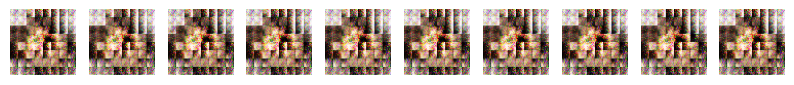

In [5]:
z = jax.random.normal(rng, (10, 64))
x_fake = generator.apply({'params': train_state[1].params}, z)
fig, axs = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axs):
    ax.imshow((x_fake[i].astype(float) + 1) / 2, cmap='gray')
    ax.axis('off')
plt.show()

Wait, but these samples are quite bad, and they are all the same. What's going on? To get some insight on what went wrong, we can plot the losses for the generator and discriminator.

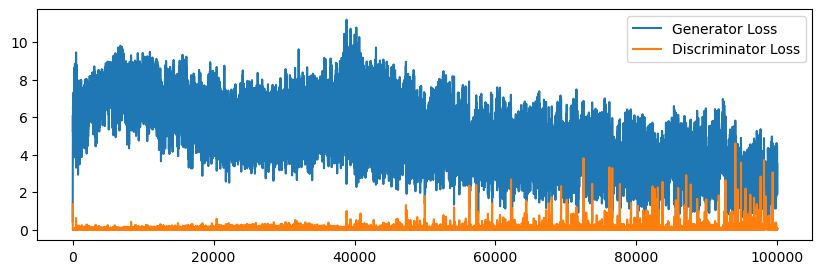

In [6]:
plot(generator_losses, discriminator_losses)

In the plot above, the discriminator has "beat" the generator very early on. The generator is creating samples with a classification log-likelihood of `-8`, which is around a `0.0003` probability of being classified as real. As we can see, the generator never recovers. **The main instability of GANs comes from the discriminator overtaking the generator**. This happens even with the non-saturating loss trick. When the discriminator becomes too powerful, there is no signal left for the generator to take advantage of, and the model collapses.

One strategy to mitigate this issue is to [train the discriminator less frequently](https://github.com/carpedm20/DCGAN-tensorflow/blob/master/model.py#L259). But this is an ugly fix, and in general, these instabilities make tuning GAN training quite annoying. Next, we'll see an alternate formulation that addresses these issues.

## Wasserstein GANs

The reason that an overly powerful discriminator is harmful is that it no longer provides a useful signal for the generator. This can often be thought of in terms of the "sharpness" of a decision boundary. Remember that our generator is trained using the gradient signal from the discriminator. When this discriminator has a very sharp boundary of classification, then gradient descent on the output probability is likely to fail. 

We can handle this by *regularizing the sharpness* of the classifier. This is the technique introduced two [Wasserstein GAN](https://arxiv.org/abs/1701.07875) (WGAN) and a [follow-up](https://arxiv.org/abs/1704.00028). The changes are as follows:
- Instead of the discriminator outputting a probablity, just output a real-valued number directly. Basically, this amounts to removing the `nn.sigmoid` and `jnp.log` transformations. Energy should be positive for real images, and negative for fake images.
- Regularize the *gradient of the discriminator output, with repect to the input image*.

The resulting minimax equation reads:

$$
\text{min}_\theta \; \text{max}_\phi \; \mathbb{E} \left[ D_\phi(x) - D_\phi(G_\theta(z)) \right] \qquad \text{st.} \qquad \nabla_x \; D_\phi(x) \leq 1
$$

Let's get an intution of why this works by comparing the GAN and WGAN formulations on a toy task:

In [139]:
def tiny_optimize(model, loss):
    rng = jax.random.PRNGKey(0)
    params = model.init(rng, jnp.ones((1, 1)))['params']
    grad_fn = jax.jit(jax.grad(loss))
    for _ in range(10000):
        grads = grad_fn(params)
        params = jax.tree_map(lambda p, g: p - 0.01 * g, params, grads)
    return params

class TinyGan(nn.Module):
    @nn.compact
    def __call__(self, x): # 2-layer MLP.
        return nn.Dense(1)(nn.relu(nn.Dense(32)(x)))[:, 0]
tiny_gan = TinyGan()

def plot_gans(x_real, x_fake, gan_params, wgan_params):
    # Plotting the results.
    x = np.linspace(-1, 1, 100)[:, None]
    gan_pred = (nn.sigmoid(tiny_gan.apply({'params': gan_params}, x)) - 0.5) * 2
    wgan_pred = tiny_gan.apply({'params': wgan_params}, x) * 0.15
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, gan_pred, label='GAN Discriminator')
    ax.plot(x, wgan_pred, label='WGAN Discriminator')
    noisy_y = jax.random.normal(jax.random.PRNGKey(2), (128, 1)) * 0.02
    ax.scatter(x_real, noisy_y, color='red', label='Real Data')
    ax.scatter(x_fake, noisy_y, color='blue', label='Fake Data')
    ax.legend()
    fig.show()

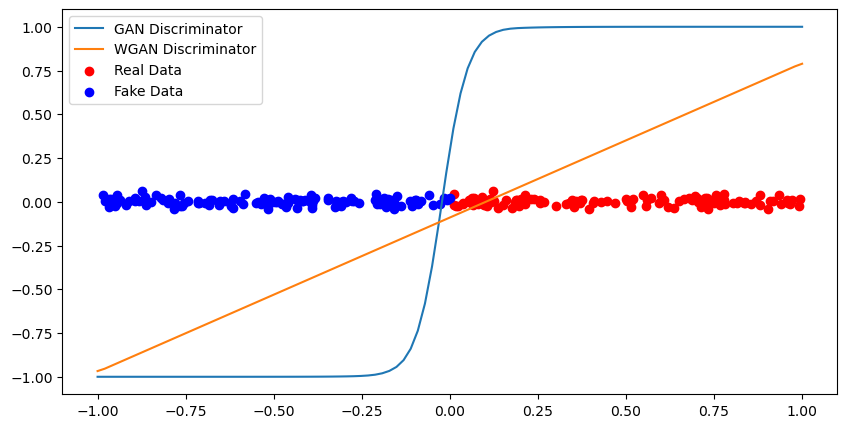

In [140]:
x_real = jax.random.uniform(jax.random.PRNGKey(0), (128, 1))
x_fake = jax.random.uniform(jax.random.PRNGKey(1), (128, 1)) - 1

def gan_loss(params):
    pred_real = tiny_gan.apply({'params': params}, x_real)
    pred_fake = tiny_gan.apply({'params': params}, x_fake)
    return -jnp.mean(jnp.log(nn.sigmoid(pred_real))) - jnp.mean(jnp.log(nn.sigmoid(1 - pred_fake)))

def wgan_loss(params):
    pred_real = tiny_gan.apply({'params': params}, x_real)
    pred_fake = tiny_gan.apply({'params': params}, x_fake)
    
    # gradient penalty
    x_all = jnp.concatenate([x_real, x_fake])
    grad = jax.grad(lambda x: jnp.sum(tiny_gan.apply({'params': params}, x)))(x_all)
    grad_norm = jnp.linalg.norm(grad, axis=1)
    return jnp.mean(pred_fake - pred_real) + 0.1 * jnp.mean((grad_norm-1) ** 2)

gan_params = tiny_optimize(tiny_gan, gan_loss)
wgan_params = tiny_optimize(tiny_gan, wgan_loss)
plot_gans(x_real, x_fake, gan_params, wgan_params)

Notice the sharp decision boundary of the naive GAN. In comparison, the WGAN results in a smooth signal. Gradient descent on the WGAN output will steadily move generations towards the decision boundary.

The regularized form of the WGAN comes with a major practical benefit: **WGAN discriminators can be trained indefinitely without collapse**. In a regular GAN, we can't train the discriminator too much, because implicitly we are trying to keep the decision boundary from becoming too sharp. In a WGAN, we explicitly regularize this behavior, so further training is not a problem.

In [150]:
@jax.jit
def loss_fn_wgan_g(params, params_d, z):
    x = generator.apply({'params': params}, z)
    fake_pred = discriminator.apply({'params': params_d}, x)
    loss = jnp.mean(-fake_pred)
    return loss

@jax.jit
def loss_fn_wgan_d(params, x_real, x_fake, rng):
    real_pred = discriminator.apply({'params': params}, x_real)
    fake_pred = discriminator.apply({'params': params}, x_fake)
    real_loss = jnp.mean(-real_pred)
    fake_loss = jnp.mean(fake_pred)

    # Gradient penalty
    eps = jax.random.uniform(rng, (x_real.shape[0], 1, 1, 1))
    samples = eps * x_real + (1 - eps) * x_fake
    def get_pred(x):
        return jnp.mean(discriminator.apply({'params': params}, x))
    grad = jax.grad(get_pred)(samples)
    assert grad.shape == samples.shape
    grad = jnp.reshape(grad, (grad.shape[0], -1))
    grad_norm = jnp.linalg.norm(grad, axis=1)
    grad_penalty = jnp.mean((grad_norm - 1)**2)

    loss = real_loss + fake_loss + grad_penalty * 10.0
    return loss

In [ ]:
discriminator = Discriminator(hidden_size=64, patch_size=8, num_patches=64)
generator = Generator(hidden_size=128, patch_size=8, num_patches=64, channels_out=3)

rng = jax.random.PRNGKey(0)
train_state_d = TrainState.create(rng, discriminator, (jnp.ones((1, 64, 64, 3)),), optax.adam(learning_rate=0.0002))
train_state_g = TrainState.create(rng, generator, (jnp.ones((1, 64)),), optax.adam(learning_rate=0.0002))
train_state = (train_state_d, train_state_g)

@jax.jit
def update_fn(train_state, x):
    ts_d, ts_g = train_state
    grad_fn_g = jax.value_and_grad(loss_fn_wgan_g, has_aux=False)
    grad_fn_d = jax.value_and_grad(loss_fn_wgan_d, has_aux=False)

    for i in range(5):
        z_key, eps_key, rng = jax.random.split(ts_d.rng, 3)
        z = jax.random.normal(z_key, (x.shape[0], 64))
        x_fake = generator.apply({'params': ts_g.params}, z)
        loss_d, grad_d = grad_fn_d(ts_d.params, x, x_fake, eps_key)
        updates_d, new_opt_state_d = ts_d.tx.update(grad_d, ts_d.opt_state, ts_d.params)
        ts_d = ts_d.replace(params=optax.apply_updates(ts_d.params, updates_d), opt_state=new_opt_state_d, rng=rng)

    z = jax.random.normal(z_key, (x.shape[0], 64))
    loss_g, grad_g = grad_fn_g(ts_g.params, ts_d.params, z)
    updates_g, new_opt_state_g = ts_g.tx.update(grad_g, ts_g.opt_state, ts_g.params)
    ts_g = ts_g.replace(params=optax.apply_updates(ts_g.params, updates_g), opt_state=new_opt_state_g)

    infos = {'loss_g': loss_g, 'loss_d': loss_d}
    return (ts_d, ts_g), (loss_g + loss_d, infos)

rng = jax.random.PRNGKey(0)
generator_losses, discriminator_losses = [], []
for i in tqdm.tqdm(range(100_000)):
    rng, batch_key = jax.random.split(rng)
    inputs, _ = next(dataset)
    train_state, (loss, infos) = update_fn(train_state, inputs)
    generator_losses.append(infos['loss_g'])
    discriminator_losses.append(infos['loss_d'])

In [ ]:
# from jaxtransformer.utils.checkpoint import Checkpoint
# cp = Checkpoint('ckpts/50000/ckpt', parallel=False)
# cp_dict = cp.load_as_dict()
# train_state_d = train_state_d.replace(**cp_dict['train_state_d'])
# train_state_g = train_state_g.replace(**cp_dict['train_state_g'])
# train_state = (train_state_d, train_state_g)

Notably, we can now use a training loop where the discriminator is updated *five* times for every generator update, without fear of collapse. Let's see how the results look.

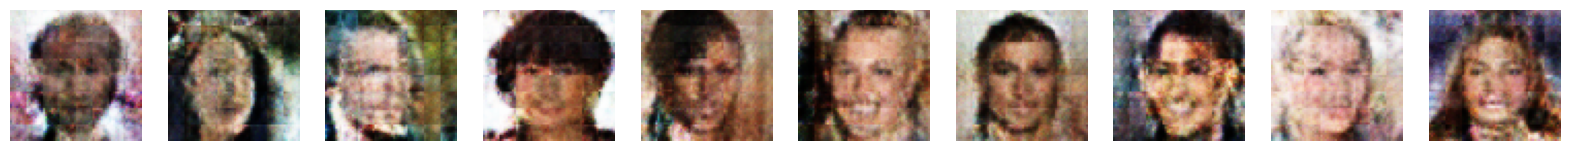

In [153]:
z = jax.random.normal(rng, (10, 64))
x_fake = generator.apply({'params': train_state[1].params}, z)
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow((x_fake[i].astype(float) + 1) / 2, cmap='gray')
    ax.axis('off')
plt.show()

In comparison to the naive GAN, the WGAN samples are much more reasonable, and don't exhibit a drastic collapse.

Unlike the blurriness problem we saw with [the VAE](4-models/variational-auto-encoder), GAN artifacts are more semantic, and are a function of model capacity and training duration. Our model is relatively small, so there's still a decent amount of artifacting. GANs have been scaled up to [large](https://arxiv.org/abs/1812.04948) [sizes](https://arxiv.org/abs/1809.11096), and represented the state-of-the-art image generation methods prior to diffusion models. For one-step generation, GANs have still yet to be surpassed.

## Interpolating in Latent Space

Similar to the VAE, a GAN generator learns a mapping from the latent variable `z` to `x`. We can interpolate in this space to get a natural progression between two images:

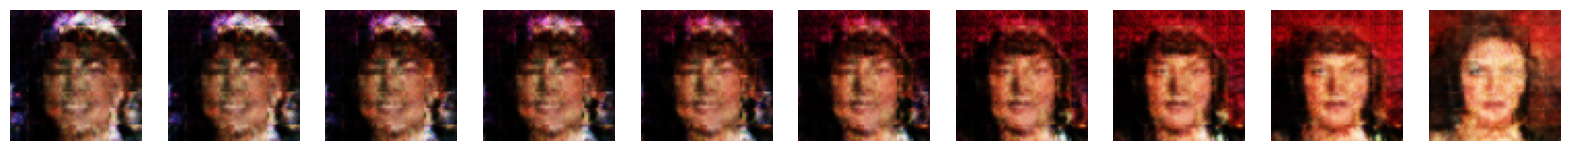

In [157]:
# Latent-Space Interpolation.
interp = np.linspace(0, 1, 10)
z0, z1 = jax.random.normal(jax.random.PRNGKey(1), (2, 64))
z_interp = z0[None, :] * interp[:, None] + z1[None, :] * np.sqrt(1 - interp[:, None]**2)
generation = generator.apply({'params': train_state[1].params}, z_interp)
img = (np.array(generation).astype(np.float32) + 1) / 2
img = np.clip(img, 0, 1)
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(img[i], cmap='gray')
    ax.axis('off')

## Is there an analytical solution to the distribution a GAN converges to?

Starting from the original minimax equation, we'll first consider the loss under a fixed generator $G_\theta(x)$ with resulting distribution $p_\theta(x)$:

$$
\begin{align}
D_\phi(\cdot) & = \text{argmax}_\phi \; \mathbb{E} \left[ \log D_\phi(x) + \log (1 - D_\phi(G_\theta(z))) \right] \\
& = \text{argmax}_\phi \; \sum_x \left[ \log D_\phi(x) p(x) + \log (1 - D_\phi(x)) p_\theta(x) \right] \\
& = \dfrac{p(x)}{p(x) + p_\theta(x)}
\end{align}
$$

where the resulting expectation is now:

$$
\begin{align}
\sum_x & \left[ \log \dfrac{p(x)}{p(x) + p_\theta(x)} p(x) + \log (1 - \dfrac{p(x)}{p(x) + p_\theta(x)}) p_\theta(x) \right] \\
& = KL(p(x) || p(x) + p_\theta(x)) + KL(p_\theta(x) || p(x) + p_\theta(x)) + C \\
& = JS(p(x) || p_\theta(x)) + C
\end{align}
$$

i.e. the Jensen-Shannon divergence between the data and generator distributions.

The generator tries to minimize this term, so we can conclude that the GAN objective (if the discriminator is trained until convergence at each step) results in minimzing the JS divergence -- which is notably only zero when the two distributions exactly match. See the [GAN paper](https://arxiv.org/abs/1406.2661) and [these notes](https://courses.grainger.illinois.edu/ece598pv/fa2017/Lecture12_GAN_AmirT.pdf) for more on the derivation.

## More details on the Wasserstein GAN

In the main section, we described WGAN in terms of its practical instantiation. The original derivation of WGAN came from a different direction, relating closer to the 'Wasserstein' term in the name.

**Wassertein distance** is a distance relating two probablity distributions (same as KL divergence), however, it additionally depends on a *metric* over the sample space. A **metric** is a function $d(a,b)$ that defines the distance between two samples. For example, a naive metric over images ('pixel metric') is just the Euclidean distance between its pixel values -- in fact, WGAN uses exactly this metric in their formulation. Metrics are powerful but can have drawbacks. The pixel metric is not accurate semantically -- an image that minimizes pixel distance between two images will result in a blurry compromise. But, assuming a metric can be helpful for regularization.

The Wasserstein distance (also known as *Earth-Mover* distance or the *optimal transport* cost) is the solution to the following problem:

$$
W(p(x)||q(x)) = \min_{\gamma} \mathbb{E}_{x,y \sim \gamma} \left[ d(a, b) \right]
$$

where $\gamma(a,b)$ is a *coupling* joint distribution whose marginal over $a$ equals $p(x)$ and over $b$ equals $q(x)$. Intuitively, think about $p(x)$ and $q(x)$ defining the starting and ending state of a pile of mass. Overall, the mass needs to be transported from the start to the end state (this is enforced by matching the marginals), and the cost of moving each piece is defined by $d(a,b)$. The Wasserstein distance is the total cost of transporting the mass, *assuming you follow the best strategy*.

![wasserstein](wasserstein.png)
> Wasserstein distance is the total cost of moving mass from $p(x)$ to $q(x)$. [[source]](https://medium.com/data-science/learning-with-minibatch-wasserstein-d87dcf52efb5)

This distance may seem intractable, but we can [take the dual](https://courses.cs.washington.edu/courses/cse599i/20au/resources/L12_duality.pdf) and form an alternative definition:

$$
W(p(\cdot)||q(\cdot)) = \max \mathbb{E}_{x \sim p(x)} [f(x)] - \mathbb{E}_{x \sim q(x)} [f(x)]
$$

where $f$ is the set of all Lipschitz-1 functions.

WGAN trains the discriminator with precisely this dual form, using the discriminator to represent $f(x)$. Originally, the Lipschitz constraint was enforced via weight clipping, but it was later found that the gradient penalty that we use in the main section was more effective.

An important thing to remember is that **WGAN is dependent on the metric we assign to samples**. For images, pixel distance seems to perform fine. But this might not be true for samples represented in other forms (e.g. frequencies, discontinuous variables, etc.)

## What causes mode collapse?

In our naive GAN example, we saw that the generator started to generate the same image over and over. This phenomenon is known as **mode collapse**, and is a common failiure of GANs. In theory, a good generator should span the space of real images (see the Jensen-Shannon argument above). But in practice, the generator may learn to ignore its noise-conditioning. If this happens, the generator may collapse to generating just a single sample, and oscillate this mode around. Mode collapse can occur in more sublte ways as well -- a generator may generate a set of good images, but still fail to capture the full extent of real images. Mode collapse is especially prominent in GANS vs. other models (e.g. diffusion or VAEs) because GANs do not use a reconstruction loss, and thus can more easily ignore data samples.